In [1]:
# This code works in Python 3.10.6
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
import dgl
from torch_geometric.datasets.dblp import DBLP
import random
import torch
from torch import optim
import torch_geometric.utils.convert
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, Linear, SAGEConv
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
from collections import Counter
import itertools
import community as community_louvain
import matplotlib.cm as cm
import os
import glob
import warnings
warnings.filterwarnings('ignore')

Create Metagraph

In [2]:
dataset = DBLP(root='./dblp_data', transform=T.Constant(node_types='conference'))
data = dataset[0]
data['conference'].pop('num_nodes')
#Create metagraph
g = torch_geometric.utils.convert.to_dgl(data)
meta_g= g.metagraph()

Original DBLP dataset with all node features

In [3]:
dataset = DBLP(root='./dblp_data', transform=T.Constant(node_types='conference'))
data = dataset[0]
print(data)

HeteroData(
  author={
    x=[4057, 334],
    y=[4057],
    train_mask=[4057],
    val_mask=[4057],
    test_mask=[4057],
  },
  paper={ x=[14328, 4231] },
  term={ x=[7723, 50] },
  conference={
    num_nodes=20,
    x=[20, 1],
  },
  (author, to, paper)={ edge_index=[2, 19645] },
  (paper, to, author)={ edge_index=[2, 19645] },
  (paper, to, term)={ edge_index=[2, 85810] },
  (paper, to, conference)={ edge_index=[2, 14328] },
  (term, to, paper)={ edge_index=[2, 85810] },
  (conference, to, paper)={ edge_index=[2, 14328] }
)


In [4]:
def feature_selection_var(X,threshold=0.0):
    sel = VarianceThreshold(threshold=(threshold * (1 - threshold)))
    fitted_X = sel.fit_transform(X)
    imp_feat = pd.DataFrame(fitted_X)

    return imp_feat

In [5]:
#all classes
# Feature selection for Author node
imp_feat_author = feature_selection_var(data['author'].x, threshold=0.83)
imp_feat_author

0    1    2    3
0     0.0  0.0  0.0  0.0
1     0.0  0.0  0.0  1.0
2     0.0  0.0  0.0  0.0
3     1.0  0.0  1.0  1.0
4     0.0  0.0  0.0  0.0
...   ...  ...  ...  ...
4052  0.0  1.0  1.0  0.0
4053  0.0  0.0  1.0  0.0
4054  0.0  0.0  0.0  0.0
4055  0.0  0.0  0.0  0.0
4056  0.0  0.0  0.0  0.0

[4057 rows x 4 columns]

In [6]:
# Paper
paper = data['paper'].x.tolist()
df_paper = pd.DataFrame(paper)
imp_feat_paper = feature_selection_var(df_paper, threshold=0.92)
imp_feat_paper

0    1    2    3
0      0.0  0.0  0.0  0.0
1      0.0  0.0  0.0  0.0
2      1.0  0.0  0.0  0.0
3      0.0  0.0  0.0  0.0
4      0.0  0.0  0.0  0.0
...    ...  ...  ...  ...
14323  1.0  0.0  0.0  0.0
14324  0.0  0.0  0.0  1.0
14325  1.0  0.0  0.0  0.0
14326  1.0  0.0  0.0  0.0
14327  1.0  0.0  0.0  0.0

[14328 rows x 4 columns]

In [7]:
data['author'].x = torch.tensor(imp_feat_author.values).to(dtype=torch.float32)
data['paper'].x = torch.tensor(imp_feat_paper.values).to(dtype=torch.float32)

DBLP dataset with selected node features used for GNN training

In [8]:
data

HeteroData(
  author={
    x=[4057, 4],
    y=[4057],
    train_mask=[4057],
    val_mask=[4057],
    test_mask=[4057],
  },
  paper={ x=[14328, 4] },
  term={ x=[7723, 50] },
  conference={
    num_nodes=20,
    x=[20, 1],
  },
  (author, to, paper)={ edge_index=[2, 19645] },
  (paper, to, author)={ edge_index=[2, 19645] },
  (paper, to, term)={ edge_index=[2, 85810] },
  (paper, to, conference)={ edge_index=[2, 14328] },
  (term, to, paper)={ edge_index=[2, 85810] },
  (conference, to, paper)={ edge_index=[2, 14328] }
)

In [9]:
#https://github.com/pyg-team/pytorch_geometric/blob/master/examples/hetero/hetero_conv_dblp.py 
class HeteroGNN(torch.nn.Module):
    def __init__(self, metadata, hidden_channels, out_channels, num_layers):
        super().__init__()

        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HeteroConv({
                edge_type: SAGEConv((-1, -1), hidden_channels)
                for edge_type in metadata[1]
            })
            self.convs.append(conv)

        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: F.leaky_relu(x) for key, x in x_dict.items()}
        return self.lin(x_dict['author'])

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)
    mask = data['author'].train_mask
    loss = F.cross_entropy(out[mask], data['author'].y[mask])
    loss.backward()
    optimizer.step()
    return float(loss)
        
@torch.no_grad()
def test():
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict).argmax(dim=-1)
    
    accs = []
    for split in ['train_mask', 'val_mask', 'test_mask']:
        mask = data['author'][split]
        acc = (pred[mask] == data['author'].y[mask]).sum() / mask.sum()
        accs.append(float(acc))
    return accs

In [10]:
#Reading from file the generated node features using diffusion
class_path = '../../../../../../../graph generator/diffusion models/sampled_features_diffusion/no_dependence/discrete_diffusion/dblp/variance/'
term_path = '../../../../../../../graph generator/diffusion models/sampled_features_diffusion/no_dependence/tabddpm/dblp/'
class0  = pd.DataFrame(torch.load(class_path + 'author0_4feat.pt').cpu().numpy())
class1  = pd.DataFrame(torch.load(class_path + 'author1_4feat.pt').cpu().numpy())
class2  = pd.DataFrame(torch.load(class_path + 'author2_4feat.pt').cpu().numpy())
class3  = pd.DataFrame(torch.load(class_path + 'author3_4feat.pt').cpu().numpy())
paper  = pd.DataFrame(torch.load(class_path + 'paper_4feat.pt').cpu().numpy())
term  = pd.DataFrame(np.load(term_path + 'term_tabddpm.npy',allow_pickle=True))

In [11]:
df_class0=class0.reset_index(drop=True)
df_class1=class1.reset_index(drop=True)
df_class2=class2.reset_index(drop=True)
df_class3=class3.reset_index(drop=True)


def get_node_features(G):
    nodes = []
    paper_node_features = []
    author_node_features = []
    author_class = []
    term_node_features = []
    conf_nodes = []
    for key, value in G.nodes(data=True):
        nodes.append(key)
        edges = [e for e in G.edges]
        
        node_id = G.nodes[key]["label"]
        node_type = G.nodes[key]["node_type"]
        
        if node_type == 0:
            paper_node = paper.loc[int(node_id), :].values.flatten().tolist()
            paper_node_features.append(paper_node)
            
        elif node_type == 1:
            node_class = random.choice([0, 1, 2, 3])
            
            if node_class == 0:
                author_node = df_class0.loc[int(node_id), :].values.flatten().tolist()
                author_class.append(0)
                author_node_features.append(author_node)
                
            elif node_class == 1:
                author_node = df_class1.loc[int(node_id), :].values.flatten().tolist()
                author_class.append(1)
                author_node_features.append(author_node)
                
            elif node_class == 2:
                author_node = df_class2.loc[int(node_id), :].values.flatten().tolist()
                author_class.append(2)
                author_node_features.append(author_node)
                
            elif node_class == 3:
                author_node = df_class3.loc[int(node_id), :].values.flatten().tolist()
                author_class.append(3)
                author_node_features.append(author_node)

        elif node_type == 2:
            term_node = term.loc[int(node_id), :].values.flatten().tolist()
            term_node_features.append(term_node)
            
        elif node_type == 3:
            conf_nodes.append(node_id)

        author_node_features_df = pd.DataFrame(author_node_features)
        author_node_features_df['class'] = author_class
        paper_node_features_df = pd.DataFrame(paper_node_features)
        term_node_features_df = pd.DataFrame(term_node_features)
        conf_nodes_df = pd.DataFrame(conf_nodes)

    return nodes, edges, author_node_features_df, paper_node_features_df, term_node_features_df, conf_nodes_df

In [12]:
def remap_indices(node_list):
    val_list = [*range(0, len(node_list), 1)]
    return dict(zip(node_list,val_list))  

In [13]:
def preprocess_edges(edgelist,node_list):
    res = [[node_list[i] for i, j in edgelist],[node_list[j] for i, j in edgelist]] 
    node_from = torch.tensor(res[0])
    node_to = torch.tensor(res[1])
    edges = torch.concat((node_from,node_to)).reshape(-1,len(node_from))
    return edges

In [14]:
def get_node_type(node_type):
    if node_type == 1:
        return 'author'
    elif node_type == 0:
        return 'paper'
    elif node_type == 2:
        return 'term'
    elif node_type == 3:
        return 'conference'

In [15]:
#List of edges in metagraph of DBLP
list(meta_g.edges())

[('author', 'paper'),
 ('paper', 'author'),
 ('paper', 'conference'),
 ('paper', 'term'),
 ('conference', 'paper'),
 ('term', 'paper')]

In [16]:
def create_dataset(nodes,edges,author_df,paper_df,term_df,conf_df,node_id,df_graph):
    author = np.asarray(author_df.drop(columns=['class']))
    paper = np.asarray(paper_df)
    term = np.asarray(term_df)
    
    x_author = torch.tensor(author).to(dtype=torch.float32)
    y_author = torch.tensor(np.array(author_df["class"]), dtype=torch.long)
    x_paper = torch.tensor(paper).to(dtype=torch.float32)
    x_term = torch.tensor(term).to(dtype=torch.float32)
    
    #Edges
    source,dest =list(map(list, zip(*edges)))

    author_to_paper = []
    paper_to_author = []
    paper_to_term = []
    paper_to_conf = []
    term_to_paper = []
    conf_to_paper = []
    remaining_edges = []

    class_dict = {'Paper':0, 'Author':1, 'Term':2,'Conference':3}

    for i in range(len(edges)):
        if (df_graph.iloc[int(source[i])]['class'] == class_dict['Author']) and \
        (df_graph.iloc[int(dest[i])]['class'] == class_dict['Paper']):
                author_to_paper.append((int(source[i]),int(dest[i])))

        elif (df_graph.iloc[int(source[i])]['class'] == class_dict['Paper']) and \
            (df_graph.iloc[int(dest[i])]['class'] == class_dict['Author']):
                paper_to_author.append((int(source[i]),int(dest[i])))

        elif (df_graph.iloc[int(source[i])]['class'] == class_dict['Paper']) and \
            (df_graph.iloc[int(dest[i])]['class'] == class_dict['Term']):
                paper_to_term.append((int(source[i]),int(dest[i])))

        elif (df_graph.iloc[int(source[i])]['class'] == class_dict['Paper']) and \
            (df_graph.iloc[int(dest[i])]['class'] == class_dict['Conference']):
                paper_to_conf.append((int(source[i]),int(dest[i])))

        elif (df_graph.iloc[int(source[i])]['class'] == class_dict['Term']) and \
            (df_graph.iloc[int(dest[i])]['class'] == class_dict['Paper']):
                term_to_paper.append((int(source[i]),int(dest[i])))

        elif (df_graph.iloc[int(source[i])]['class'] == class_dict['Conference']) and \
            (df_graph.iloc[int(dest[i])]['class'] == class_dict['Paper']):
                conf_to_paper.append((int(source[i]),int(dest[i])))

        else:
            #The edges not present in the metagraph  
            source_node_type = get_node_type(df_graph.iloc[int(source[i])]['class'])
            dest_node_type = get_node_type(df_graph.iloc[int(dest[i])]['class'])
            remaining_edges.append((source_node_type,dest_node_type))
            
            
    all_edges[node_id] = [*author_to_paper,*paper_to_author,*paper_to_term,*paper_to_conf,*term_to_paper,
                          *conf_to_paper]
            
    author = list(df_graph[df_graph['class'] == 1]['nodeId'])
    author = [int(i) for i in author]
    author_nodes_mapping = remap_indices(author)
    paper = list(df_graph[df_graph['class'] == 0]['nodeId'])
    paper = [int(i) for i in paper]
    paper_nodes_mapping = remap_indices(paper)
    term = list(df_graph[df_graph['class'] == 2]['nodeId'])
    term = [int(i) for i in term]
    term_nodes_mapping = remap_indices(term)
    conf = list(df_graph[df_graph['class'] == 3]['nodeId'])
    conf = [int(i) for i in conf]
    conf_nodes_mapping = remap_indices(conf)


    node_list = {}
    for d in [author_nodes_mapping, paper_nodes_mapping, term_nodes_mapping,conf_nodes_mapping]:
            node_list.update(d)            

    #Create Hetero Data      
    small_graph = HeteroData({'author':{'x': x_author, 'y':y_author}, 'paper':{'x': x_paper},
                              'term':{'x': x_term}, 'conference':{'num_nodes': conf_nodes.shape[0]}})

    if author_to_paper:
        edge_index_author_paper = preprocess_edges(author_to_paper,node_list)
        small_graph['author','to','paper'].edge_index = edge_index_author_paper

    if paper_to_author:
        edge_index_paper_author = preprocess_edges(paper_to_author,node_list)
        small_graph['paper','to','author'].edge_index = edge_index_paper_author

    if paper_to_term:
        edge_index_paper_term = preprocess_edges(paper_to_term,node_list)
        small_graph['paper','to','term'].edge_index = edge_index_paper_term

    if paper_to_conf:
        edge_index_paper_conf = preprocess_edges(paper_to_conf,node_list) 
        small_graph['paper','to','conference'].edge_index = edge_index_paper_conf

    if term_to_paper:
        edge_index_term_paper = preprocess_edges(term_to_paper,node_list) 
        small_graph['term','to','paper'].edge_index = edge_index_term_paper

    if conf_to_paper:
        edge_index_conf_paper = preprocess_edges(conf_to_paper,node_list)
        small_graph['conference','to','paper'].edge_index = edge_index_conf_paper

    transform = T.Constant(node_types='conference')
    small_graph = transform(small_graph)
    
    #Removing isolated nodes
    transform = T.Compose([T.remove_isolated_nodes.RemoveIsolatedNodes()])
    small_graph = transform(small_graph)
    #Adding test mask for prediction
    transform = T.RandomNodeSplit(split='train_rest', num_val=0.0, num_test=1.0)
    small_graph = transform(small_graph)
            
    return small_graph, remaining_edges

In [17]:
def evaluate_gnn(small_graph):
    with torch.no_grad():
        model.eval()
        small_graph= small_graph.to(device)
        
        #Getting class prediction probabilities from the softmax layer
        softmax = model(small_graph.x_dict, small_graph.edge_index_dict).softmax(dim=-1)

        return softmax.tolist()

In [18]:
graphs_path = '../../../../../../../graph generator/diffusion models/sampled_graphs_diffusion/' 
print('Original no of graphs:',len([name for name in glob.iglob(graphs_path + 'dblp_10to15/*.gexf')]))

Original no of graphs: 1416


In [19]:
avg_max_pred_list = []
max_pred_list = []
graph_dict_list = []
softmax_dict_list = []
nodefeature_dict_list = []
all_edges_list = []
class_graphid_list = []

In [20]:
def get_max_pred(softmax_dict,i):
    #Getting the list of predictions for each class
    prob_class0_dict = {}
    prob_class1_dict = {}
    prob_class2_dict = {}
    prob_class3_dict = {}
    for nodeid in softmax_dict:
        list0= []
        list1= []
        list2= []
        list3= []
        if len(softmax_dict[nodeid]) > 0:
            list0= []
            list1= []
            list2= []
            list3= []
    
            for prob in softmax_dict[nodeid]:        
                list0.append(prob[0])        
                list1.append(prob[1]) 
                list2.append(prob[2]) 
                list3.append(prob[3])
    
         #Taking max probability of all nodes of each class in a graph
        if len(list0) != 0:
            prob_class0_dict[nodeid]=max(list0)
        if len(list1) != 0:    
            prob_class1_dict[nodeid]=max(list1)
        if len(list2) != 0:    
            prob_class2_dict[nodeid]=max(list2)
        if len(list3) != 0:    
            prob_class3_dict[nodeid]=max(list3)

    max_pred0 = max(prob_class0_dict.values())
    max_pred1 = max(prob_class1_dict.values())
    max_pred2 = max(prob_class2_dict.values())
    max_pred3 = max(prob_class3_dict.values())

    print('Run'+str(i), max_pred0, max_pred1, max_pred2, max_pred3)
    max_pred_list.append([max_pred0, max_pred1, max_pred2, max_pred3])

    graph_dict_list.append(graph_dict)
    all_edges_list.append(all_edges)
    softmax_dict_list.append(softmax_dict)
    nodefeature_dict_list.append(nodefeature_dict)
    
    avg_max_pred = (max_pred0+max_pred1+max_pred2+max_pred3)/4
    avg_max_pred_list.append(avg_max_pred)
    
    class0_graphid = max(prob_class0_dict, key=prob_class0_dict.get)
    class1_graphid = max(prob_class1_dict, key=prob_class1_dict.get)
    class2_graphid = max(prob_class2_dict, key=prob_class2_dict.get)
    class3_graphid = max(prob_class3_dict, key=prob_class3_dict.get)

    class_graphid_list.append([class0_graphid,class1_graphid,class2_graphid,class3_graphid])

In [21]:
for i in range(0,10):     

    model = HeteroGNN(data.metadata(), hidden_channels=64, out_channels=4,
                  num_layers=2)
    
    #device =  'cpu'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    data, model = data.to(device), model.to(device)
    
    with torch.no_grad():  # Initialize lazy modules.
        out = model(data.x_dict, data.edge_index_dict)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.001)
    
    best_val_acc = 0
    start_patience = patience = 100
    for epoch in range(1, 500):
        loss = train()
        train_acc, val_acc, test_acc = test()
        if epoch%200==0:
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, '
              f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')
    
        if best_val_acc <= val_acc:
            patience = start_patience
            best_val_acc = val_acc
        else:
            patience -= 1
    
        if patience <= 0:
            print('Stopping training as validation accuracy did not improve '
                  f'for {start_patience} epochs')
            break

        
    all_edges = {}
    softmax_dict = {}
    nodefeature_dict = {}
    graph_dict = {}

    #Read from file the synthetic graphs generated using diffusion to evaluate the trained GNN on the graphs
    for filepath in glob.iglob(graphs_path + 'dblp_10to15/*.gexf'):
        
        graph = nx.read_gexf(filepath)
    
        filename = os.path.basename(filepath)
        graph_id= filename.split('.')[0]
    
        nodeId_list = []
        node_type_list = []
    
        for key, value in graph.nodes(data=True):
            nodeId_list.append(key)
            node_type_list.append(value['node_type'])
     
        df_graph = pd.DataFrame()
        df_graph["nodeId"] = nodeId_list
        df_graph["class"] = node_type_list
      
    
        nodes,edges,author_node_features,paper_node_features,term_node_features,conf_nodes= get_node_features(graph)
        small_graph_data, removed_edges = create_dataset(nodes,edges,
                                  author_node_features,paper_node_features,
                                  term_node_features,conf_nodes,graph_id,df_graph)
        
    
        if (small_graph_data['author'].x.nelement()!=0) and \
        (small_graph_data['paper','to','author']) and \
        (small_graph_data['author','to','paper']) and \
        (small_graph_data['paper','to','conference']) and \
        (small_graph_data['paper','to','term']):
            
            softmax = evaluate_gnn(small_graph_data)
            softmax_dict[graph_id] = softmax
            nodefeature_dict[graph_id]={'author':small_graph_data['author'].x,
                                             'paper':small_graph_data['paper'].x,
                                             'term':small_graph_data['term'].x}
            graph_dict[graph_id]=df_graph
    
    print("No. of graphs evaluated: ",len(softmax_dict))

    get_max_pred(softmax_dict,i)


Stopping training as validation accuracy did not improve for 100 epochs
No. of graphs evaluated:  231
Run0 1.0 0.9759012460708618 0.9996007084846497 0.9893726706504822
Stopping training as validation accuracy did not improve for 100 epochs
No. of graphs evaluated:  231
Run1 1.0 0.9999786615371704 0.9997890591621399 0.8018253445625305
Stopping training as validation accuracy did not improve for 100 epochs
No. of graphs evaluated:  231
Run2 1.0 0.993306577205658 0.9881137013435364 0.8112214803695679
Stopping training as validation accuracy did not improve for 100 epochs
No. of graphs evaluated:  231
Run3 1.0 0.999916672706604 0.9999867677688599 0.5499395728111267
Stopping training as validation accuracy did not improve for 100 epochs
No. of graphs evaluated:  231
Run4 1.0 0.998573899269104 0.9974083304405212 0.25584933161735535
Stopping training as validation accuracy did not improve for 100 epochs
No. of graphs evaluated:  231
Run5 1.0 0.9984496831893921 0.9999866485595703 0.52010262012

In [22]:
avg_max_pred_list

[0.9912186563014984,
 0.9503982663154602,
 0.9481604397296906,
 0.8874607533216476,
 0.8129578903317451,
 0.8796347379684448,
 0.9294759929180145,
 0.7351400293409824,
 0.8407463058829308,
 0.7745241485536098]

In [76]:
print('Mean',np.mean(avg_max_pred_list))

Mean 0.8749717220664024


In [77]:
print('Standard Deviation',np.std(avg_max_pred_list))

Standard Deviation 0.07897293751918043


In [24]:
m = max(avg_max_pred_list)
index = avg_max_pred_list.index(m)
index

0

In [25]:
def plot_graph(graphid, max_pred,nodetype,edges,graph):

    classes = []
    G = nx.Graph(edges)
    df_graph = graph_dict[graphid]
    
    for g in G.nodes():      
        if df_graph.loc[g]['class'] == 0:
            classes.append(0)
        if df_graph.loc[g]['class'] == 1:
            classes.append(1)
        if df_graph.loc[g]['class'] == 2:
            classes.append(2)
        if df_graph.loc[g]['class'] == 3:
            classes.append(3)
   
    
    color_class_map = {0: 'blue', 1: 'red', 2: 'darkgreen', 3: 'orange'}
    
    nx.set_node_attributes(G, dict(zip(G.nodes(), classes)), 'class')
    
    print('Number of nodes: ',G.number_of_nodes())
    print('graph id: ',graphid)
    print(f'Max pred probability for class {nodetype} is {max_pred}')

    nx.draw(G, 
    with_labels=False, node_color=[color_class_map[node[1]['class']] 
                        for node in G.nodes(data=True)], 
            node_size=100,
        font_color='black')
    plt.show()

In [26]:
def index_2d(prob_list, v):
    for i, x in enumerate(prob_list):
        if v in x:
            return (i, x.index(v))

In [27]:
plt.rcParams.update({'axes.ymargin': 0.2})

In [28]:
def count_plot(feat_list):
    fig, ax = plt.subplots(figsize=(7, 7))
    sns.countplot(x=0,ax=ax,data=pd.DataFrame(feat_list),width=0.3)
    for i in ax.containers:
        ax.bar_label(i,fontsize=30)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.xlabel('feature values',fontsize=30)
    plt.ylabel('feature count',fontsize=30)

    plt.show()

In [29]:
def plot_imp_feature(feat_list):
    fig, ax = plt.subplots(figsize=(7, 7))
    sns.countplot(x=0,ax=ax,data=pd.DataFrame(feat_list),width=0.3)
    for i in ax.containers:
        ax.bar_label(i,fontsize=30)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.xlabel('feature values',fontsize=30)
    plt.ylabel('no. of samples',fontsize=30)

    plt.show()

In [30]:
class0_graphid = class_graphid_list[index][0]
class1_graphid = class_graphid_list[index][1]
class2_graphid = class_graphid_list[index][2]
class3_graphid = class_graphid_list[index][3]

In [31]:
max_pred0 = max_pred_list[index][0]
max_pred1 = max_pred_list[index][1]
max_pred2 = max_pred_list[index][2]
max_pred3 = max_pred_list[index][3]

In [32]:
all_edges = all_edges_list[index]

In [33]:
graph_dict = graph_dict_list[index]

In [34]:
softmax_dict = softmax_dict_list[index]

In [35]:
nodefeature_dict = nodefeature_dict_list[index]

Plotting explanation graph and node features for each class of Author node

Node colors:

Paper - Blue

Author - Red

Term - Darkgreen

Conference - Orange

Number of nodes:  10
graph id:  graph0
Max pred probability for class 0 is 1.0


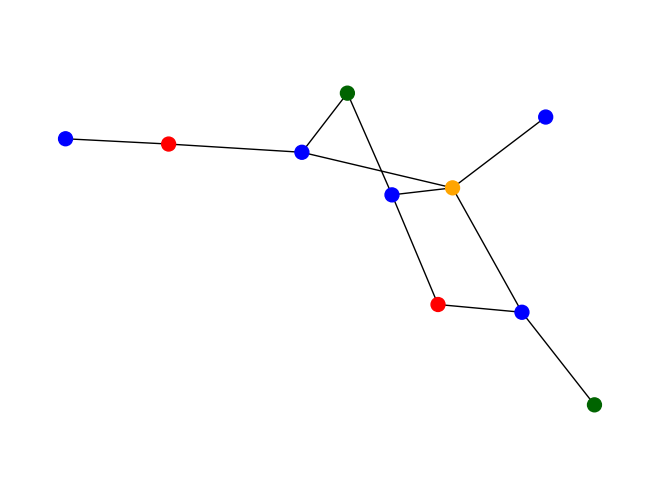

In [36]:
explanation_graph0 = plot_graph(class0_graphid, max_pred0, 0, all_edges[class0_graphid],graph_dict[class0_graphid])

In [37]:
ind= index_2d(softmax_dict[class0_graphid], max_pred0)[0]
list0= nodefeature_dict[class0_graphid]['author'].cpu().numpy()[ind]
Counter(list0)

Counter({1.0: 4})

In [38]:
print(list0)

[1. 1. 1. 1.]


In [39]:
index_2d(softmax_dict[class0_graphid], max_pred0)

(1, 0)

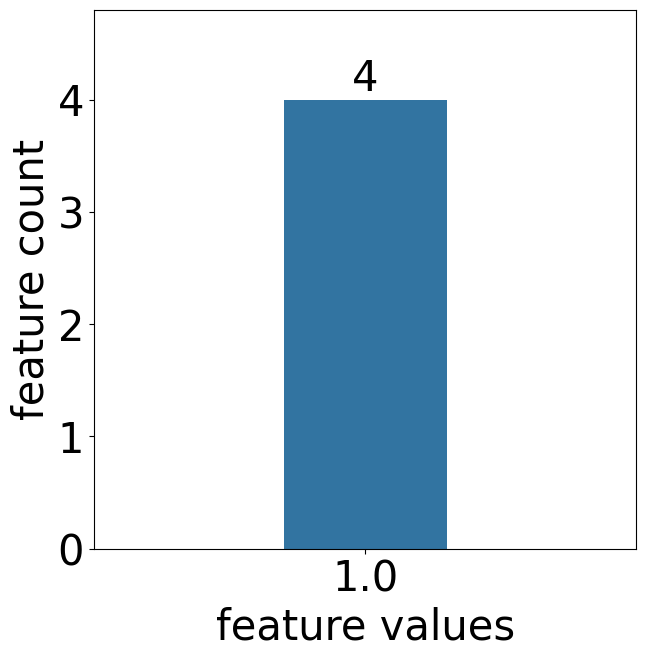

In [40]:
count_plot(list0)

Number of nodes:  15
graph id:  graph1249
Max pred probability for class 1 is 0.9759012460708618


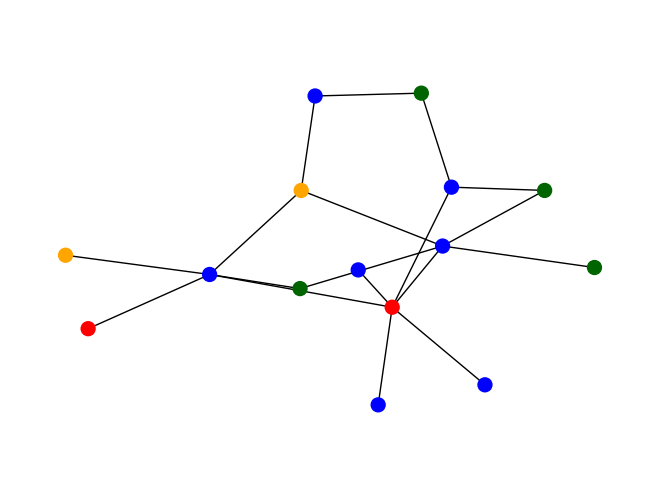

In [41]:
explanation_graph1 = plot_graph(class1_graphid, max_pred1, 1, all_edges[class1_graphid],graph_dict[class1_graphid])

In [42]:
ind= index_2d(softmax_dict[class1_graphid], max_pred1)[0]
list1= nodefeature_dict[class1_graphid]['author'].cpu().numpy()[ind]
Counter(list1)

Counter({1.0: 2, 0.0: 2})

In [43]:
print(list1)

[1. 0. 1. 0.]


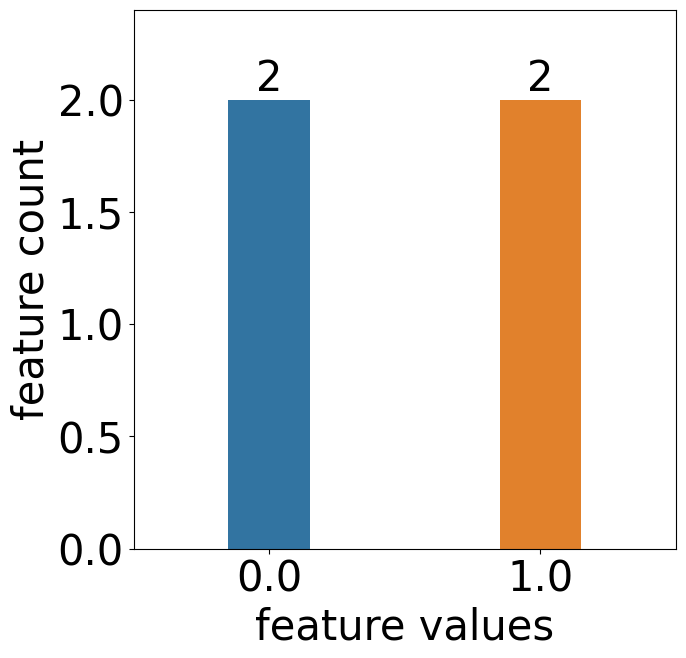

In [44]:
count_plot(list1)

Number of nodes:  10
graph id:  graph97
Max pred probability for class 2 is 0.9996007084846497


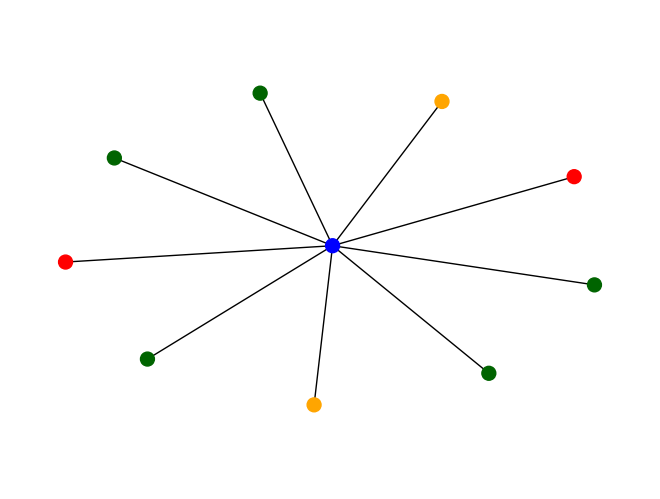

In [45]:
explanation_graph2 = plot_graph(class2_graphid, max_pred2, 2, all_edges[class2_graphid],graph_dict[class2_graphid])

In [46]:
ind= index_2d(softmax_dict[class2_graphid], max_pred2)[0]
list2= nodefeature_dict[class2_graphid]['author'].cpu().numpy()[ind]
Counter(list2)

Counter({1.0: 3, 0.0: 1})

In [47]:
print(list2)

[1. 1. 1. 0.]


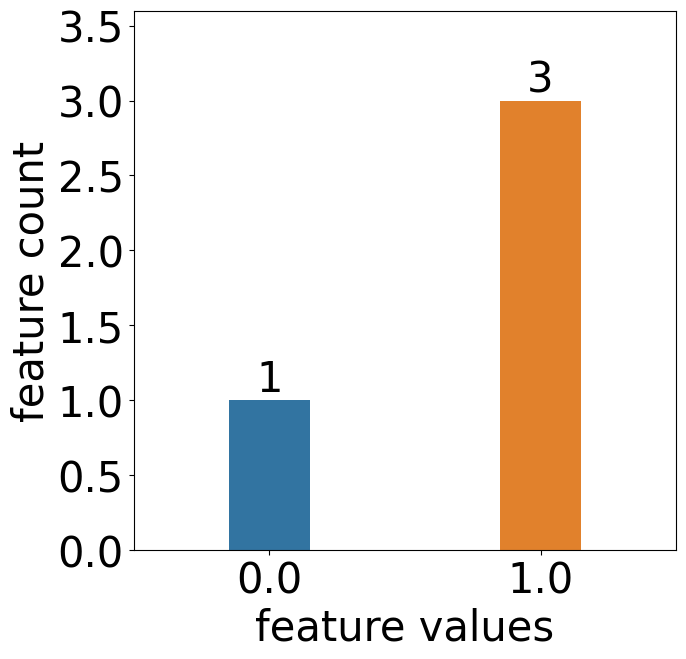

In [48]:
count_plot(list2)

Number of nodes:  15
graph id:  graph1406
Max pred probability for class 3 is 0.9893726706504822


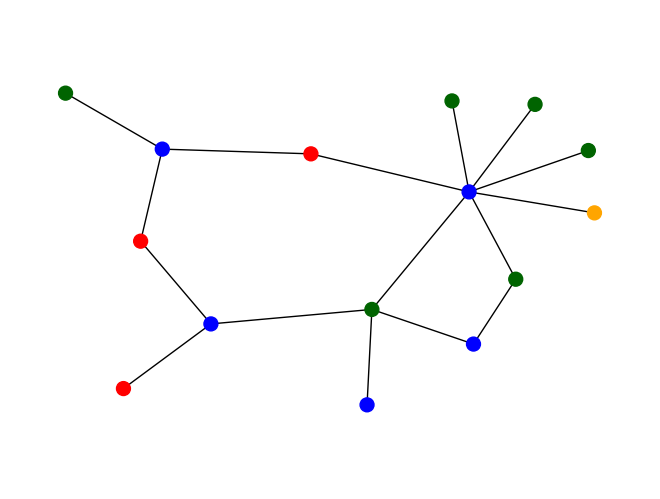

In [49]:
explanation_graph3 = plot_graph(class3_graphid, max_pred3, 3, all_edges[class3_graphid],graph_dict[class3_graphid])

In [50]:
ind= index_2d(softmax_dict[class3_graphid], max_pred3)[0]
list3= nodefeature_dict[class3_graphid]['author'].cpu().numpy()[ind]
Counter(list3)

Counter({1.0: 3, 0.0: 1})

In [51]:
print(list3)

[1. 1. 1. 0.]


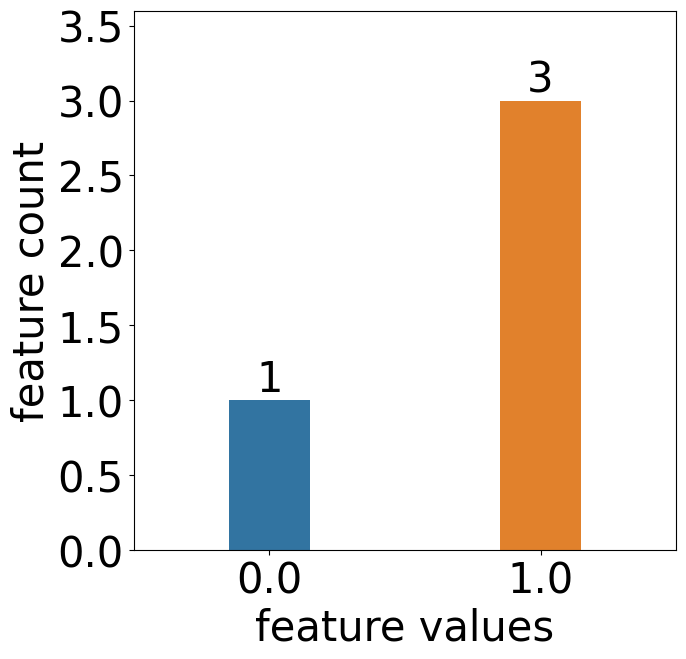

In [52]:
count_plot(list3)

In [53]:
def print_stat_cont_features(df):
    print('mean',df.stack().mean())
    print('std dev',df.stack().std())

In [54]:
def plot_node_feat(imp_feat):
    sns.distplot(imp_feat,color= 'orange',hist= False)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('Feature values',fontsize=20)
    plt.ylabel('Density',fontsize=20)

    plt.show()  

In [55]:
def feature_selection(df_sampled):
    col_sum = df_sampled.sum(axis=0)
    sorted_colsum = sorted(col_sum, reverse=True)

    index_list = []
    for i in sorted_colsum[:1]:
        index_list.append(list(col_sum).index(i))
        imp_feat = df_sampled[index_list].reset_index(drop=True)
        return imp_feat

In [56]:
#Term Feature Statistics
term0_df = pd.DataFrame(nodefeature_dict[class0_graphid]['term'].cpu().numpy())
print_stat_cont_features(term0_df)

mean 0.13714103
std dev 1.7533951


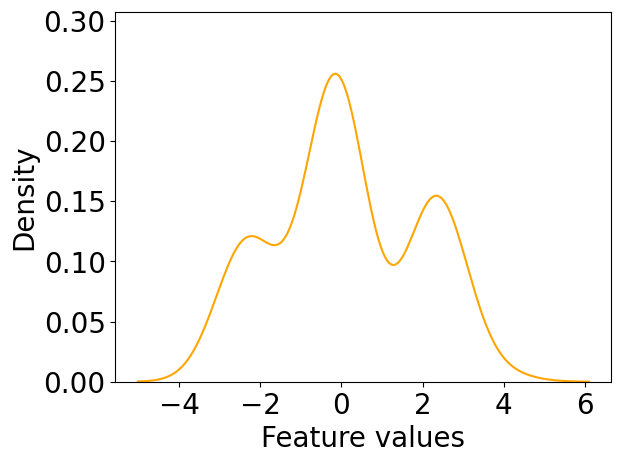

In [57]:
plot_node_feat(term0_df)

In [58]:
term1_df = pd.DataFrame(nodefeature_dict[class1_graphid]['term'].cpu().numpy())
print_stat_cont_features(term1_df)

mean 0.03336672
std dev 0.6937648


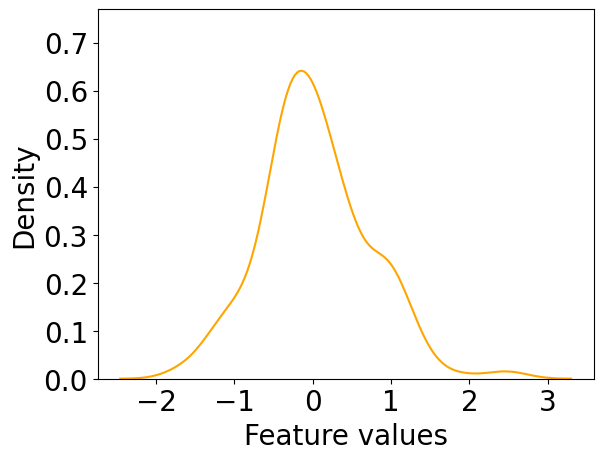

In [59]:
plot_node_feat(term1_df)

In [60]:
term2_df = pd.DataFrame(nodefeature_dict[class2_graphid]['term'].cpu().numpy())
print_stat_cont_features(term2_df)

mean -0.021435464
std dev 1.0813441


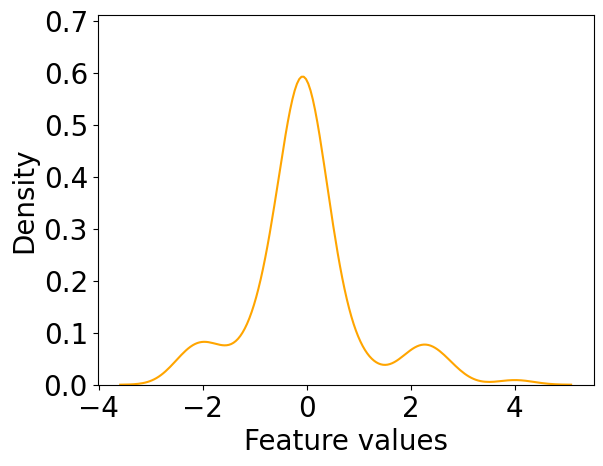

In [61]:
plot_node_feat(term2_df)

In [62]:
term3_df = pd.DataFrame(nodefeature_dict[class3_graphid]['term'].cpu().numpy())
print_stat_cont_features(term3_df)

mean 0.051450673
std dev 1.1755756


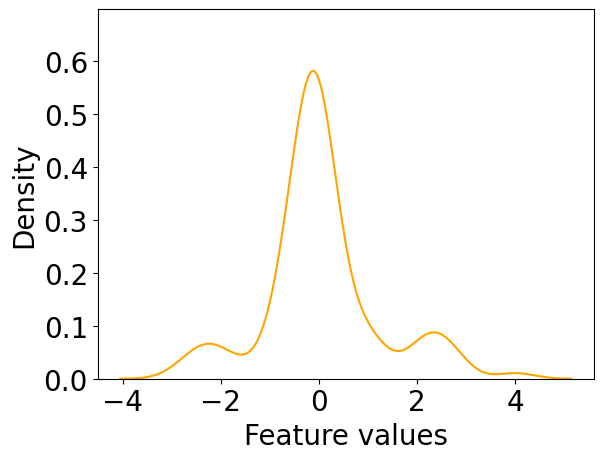

In [63]:
plot_node_feat(term3_df)

In [64]:
#Paper Features
paper0_df = pd.DataFrame(nodefeature_dict[class0_graphid]['paper'].cpu().numpy())

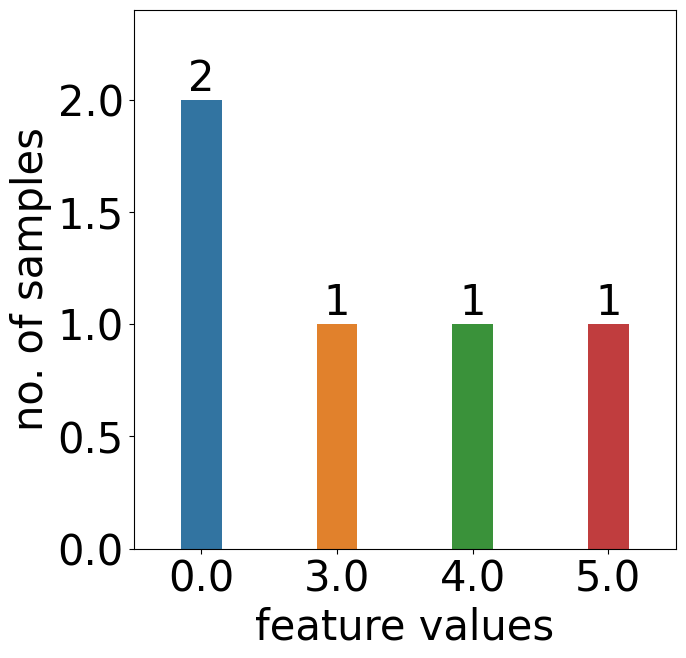

In [65]:
imp_paper_feat0=feature_selection(paper0_df)
plot_imp_feature(imp_paper_feat0.values.tolist())

In [66]:
paper1_df = pd.DataFrame(nodefeature_dict[class1_graphid]['paper'].cpu().numpy())

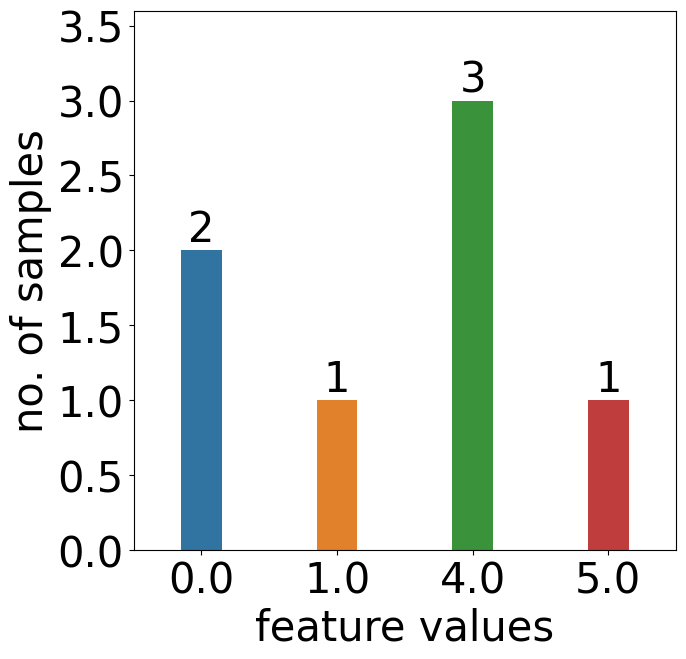

In [67]:
imp_paper_feat1=feature_selection(paper1_df)
plot_imp_feature(imp_paper_feat1.values.tolist())

In [68]:
paper2_df = pd.DataFrame(nodefeature_dict[class2_graphid]['paper'].cpu().numpy())

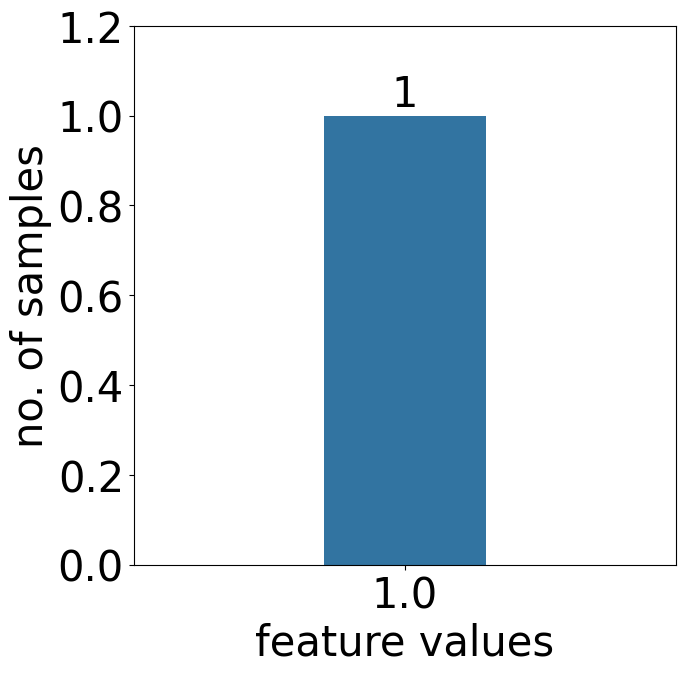

In [69]:
imp_paper_feat2=feature_selection(paper2_df)
plot_imp_feature(imp_paper_feat2.values.tolist())

In [70]:
paper3_df = pd.DataFrame(nodefeature_dict[class3_graphid]['paper'].cpu().numpy())

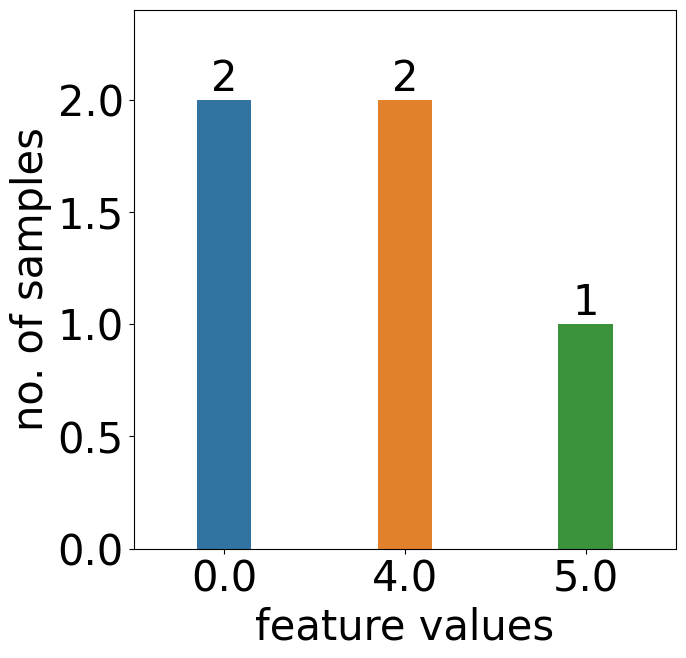

In [71]:
imp_paper_feat3=feature_selection(paper3_df)
plot_imp_feature(imp_paper_feat3.values.tolist())

In [4]:
motifs_path = '../../../../../common_motifs/dblp_10to15/'
files_motif = os.listdir(motifs_path)

In [5]:
for index_m, file_m in enumerate(files_motif):
    filepath_m = os.path.join(motifs_path, file_m)
    print(filepath_m)

../../../../../common_motifs/dblp_10to15/motif_real_10_0.gexf
../../../../../common_motifs/dblp_10to15/motif_real_10_1.gexf
../../../../../common_motifs/dblp_10to15/motif_real_10_2.gexf
../../../../../common_motifs/dblp_10to15/motif_real_10_3.gexf
../../../../../common_motifs/dblp_10to15/motif_real_10_4.gexf
../../../../../common_motifs/dblp_10to15/motif_real_11_0.gexf
../../../../../common_motifs/dblp_10to15/motif_real_11_1.gexf
../../../../../common_motifs/dblp_10to15/motif_real_11_2.gexf
../../../../../common_motifs/dblp_10to15/motif_real_11_3.gexf
../../../../../common_motifs/dblp_10to15/motif_real_11_4.gexf
../../../../../common_motifs/dblp_10to15/motif_real_12_0.gexf
../../../../../common_motifs/dblp_10to15/motif_real_12_1.gexf
../../../../../common_motifs/dblp_10to15/motif_real_12_2.gexf
../../../../../common_motifs/dblp_10to15/motif_real_12_3.gexf
../../../../../common_motifs/dblp_10to15/motif_real_12_4.gexf
../../../../../common_motifs/dblp_10to15/motif_real_13_0.gexf
../../..

In [74]:
def get_faithfulness(graphid_list):
    class_faithfulness = []
    for graphid in graphid_list:
        expln_graph = nx.Graph(all_edges[graphid])
        edges = all_edges_list[i][graphid]
        expln_graph = nx.Graph(edges)

        fid_score_list = []       
        for index_m, file_m in enumerate(files_motif):
            filepath_m = os.path.join(motifs_path, file_m)

            motif_graph = nx.read_gexf(filepath_m)

            GM = nx.algorithms.isomorphism.GraphMatcher(expln_graph,motif_graph)
            x = 1 if GM.subgraph_is_isomorphic() else 0    
            fid_score_list.append(x)

        class_faithfulness.append(np.mean(fid_score_list))

    return np.mean(class_faithfulness)

In [78]:
faithfulness_list = []

for i in range(0,10):
    faithfulness = get_faithfulness(class_graphid_list[i])

    print('Run'+str(i),faithfulness)
    faithfulness_list.append(faithfulness)
print('Mean',np.mean(faithfulness_list))

Run0 0.675
Run1 0.8583333333333334
Run2 0.6
Run3 0.7749999999999999
Run4 0.675
Run5 0.625
Run6 0.6833333333333333
Run7 0.6166666666666667
Run8 0.65
Run9 0.65
Mean 0.6808333333333334


In [79]:
print('Standard Deviation',np.std(faithfulness_list))

Standard Deviation 0.07491198539323034
